<center>
    <h3>Arnaud Chéridi</h3>
    <p>Étudiant en Master 2 Mathématiques Appliquées</p>
    <p>Projet individuel : Modélisation du risque de crédit (cas IFRS 9)</p>
    <p>Objectif : développer un modèle de PD (score > 65%) + LGD + simulation</p>
</center>

<center><h2> 4. Simulation de l'Exposition au moment du défaut <h2><center>

## Contexte

Après avoir sélectionné et calibré des modèles pour estimer les probabilités de défaut (`PD`) et les pertes en cas de défaut (`LGD`) à partir d’un jeu de données crédit, nous poursuivons notre analyse du risque de crédit en simulant trois grandeurs fondamentales dans le cadre de la norme IFRS 9 :

- **EAD (Exposure at Default)** : Exposition attendue au moment du défaut, c’est-à-dire le montant encore dû au moment où le client fait défaut.
- **EAC (Expected Annualized Cost)** : Perte attendue ponctuelle à un instant donné, calculée sur les flux de remboursement mensuels.
- **ECL (Expected Credit Loss)** : Perte attendue totale si le défaut survient à un instant donné, en tenant compte de l’ensemble de l’encours restant.

Ces simulations s’inscrivent dans une logique prospective de type "lifetime expected loss" et permettent de mieux quantifier l’évolution du risque dans le temps.

---

## Objectifs

L’objectif de cette étape est de :

- Simuler, **mois par mois**, la dynamique du portefeuille de crédits,
- Reproduire l'entrée en défaut aléatoire des clients, basée sur leur `PD`,
- Calculer à chaque pas de temps :
  - l’**EAD** : somme des encours restants des clients **au moment où ils font défaut**,
  - l’**EAC** : perte attendue instantanée, calculée comme `PD × LGD × remboursement_mensuel`,
  - l’**ECL** : perte attendue totale, calculée comme `PD × LGD × encours restant` pour chaque client actif,
- Répéter ce processus via une **simulation Monte Carlo**, pour obtenir une estimation robuste de l’évolution dans le temps du risque,
- Visualiser l’incertitude par une **moyenne et une bande de confiance** autour des trajectoires.

---

## Méthodologie

1. **Initialisation** :
   - On duplique le dataset original, en ajoutant des colonnes `defaulted` (booléen), `mois_defaut` (entier), `ead_defaut` (float).

2. **Simulation temporelle (mois par mois)** :
   - Chaque mois, pour chaque client encore actif :
     - On tire un uniforme $U \sim \mathcal{U}(0,1)$,
     - Si $U < \text{PD}$, le client entre en **défaut** à ce mois.
   - On marque les défauts et on les exclut des mois suivants.

3. **Calcul des indicateurs** :
   - `EAD(t)` : somme des montants encore dus par les clients **ayant fait défaut** à $t$,
   - `EAC(t)` : somme des pertes attendues sur les **flux mensuels** (encore actifs),
   - `ECL(t)` : somme des pertes attendues sur les **encours restants** (encore actifs), i.e. $PD \times LGD \times EAD(t)$.

4. **Monte Carlo (N simulations)** :
   - Le processus est répété $N$ fois (par exemple $N = 1000$),
   - À chaque itération, on stocke `EAD(t)`, `EAC(t)`, et `ECL(t)` sur l’horizon de simulation,
   - On extrait ensuite la **moyenne**, l’**écart-type**, et les **bandes de confiance**.

---

## Résultat attendu

Les graphiques finaux permettent de visualiser :
- L’évolution moyenne de l’**exposition au risque** (`EAD`),
- Le **coût du risque mensuel** (`EAC`), et la **perte attendue totale** (`ECL`) dans le temps,
- L’impact de l’aléa de défaut sur les flux futurs,
- L’incertitude du portefeuille via les bandes $\pm 2\sigma$ autour de la moyenne.

---

> Ces simulations permettent de mieux anticiper les pertes attendues sur un portefeuille de crédits, d’affiner le provisionnement IFRS 9, et de structurer des exercices de stress testing ou d’allocation de capital économique.

## 0. Import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

import joblib

## 1. Chargement des données et des modèles

In [2]:
train_final = pd.read_csv("data/train_final.csv")
test_final = pd.read_csv("data/test_final.csv")
full_df = pd.concat([train_final, test_final], axis=0)

df = full_df.drop(columns=["TARGET", "SK_ID_CURR", "LGD_sim", "LGD_sim_NA"])

model_pd = joblib.load("model_pd.pkl")
model_lgd = joblib.load("model_lgd.pkl")

## 2. Calcul de la PD et de LGD avec nos modèles et calcul

In [3]:
df["PD"] = model_pd.predict_proba(df)[:,1]
df["LGD"] = model_lgd.predict(df.drop(columns=["PD"]))

/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


- `duree_credit_mois` : estimation de la **durée du crédit en mois**, en supposant que le montant total des revenus sert à rembourser l'annuité.
- `remboursement_mensuel` : estimation du **montant mensuel remboursé**

In [4]:
df["duree_credit_mois"] = (df["AMT_INCOME_TOTAL"]/df["AMT_ANNUITY"]*12).astype(int)
df["remboursement_mensuel"] = df["AMT_ANNUITY"]/12

## 3. Mise en place des planchers

Les planchers suivants sont appliqués conformément aux exigences **réglementaires (IFRS 9 / Bâle II/III)** :

- **Probabilité de défaut minimale (PD)** :
  - *Cash loans* : 0.05 % (`0.0005`)
  - *Revolving loans* : 0.10 % (`0.001`)

- **Loss Given Default minimale (LGD)** :
  - *Cash loans* : 15 % (`0.15`)
  - *Revolving loans* : 70 % (`0.70`)

Ces **valeurs minimales** sont imposées pour éviter une sous-estimation excessive du risque de crédit.

In [5]:
plancher_pd = {
    'Cash loans': 0.0005,       # 0.05%
    'Revolving loans': 0.001    # 0.10%
}

plancher_lgd = {
    'Cash loans': 0.15,         # 15%
    'Revolving loans': 0.70     # 70%
}

In [6]:
# Fonction d'ajustement des valeurs plancher
def appliquer_planchers(row):
    type_credit = row['NAME_CONTRACT_TYPE']
    row['PD'] = max(row['PD'], plancher_pd.get(type_credit, 0))
    row['LGD'] = max(row['LGD'], plancher_lgd.get(type_credit, 0))
    return row

# Application au DataFrame
df = df.apply(appliquer_planchers, axis=1)

## 4. Simulation de l'EAC, l'EAD et l'ECL

## Objectif de la simulation Monte Carlo

L’objectif de cette simulation est d’estimer dynamiquement l’évolution des indicateurs de risque liés à un portefeuille de crédits, en tenant compte de l’incertitude de défaut. Plus précisément, on calcule à chaque pas de temps :

- **l’EAD au moment du défaut** : `ead_defaut_montecarlo`
- **la perte attendue mensuelle (EAC)** : `eac_montecarlo`
- **la perte attendue totale (ECL)** : `ecl_montecarlo`
- **l’encours encore actif** dans le portefeuille : `encours_total_montecarlo`

Le processus est répété **M = 1000 fois** (simulation de Monte Carlo), mois par mois, jusqu’à la durée maximale observée (`temps_max`).

---

### Déroulé d’une simulation unique

À chaque simulation, on répète la procédure suivante :

- Pour chaque client encore actif :
  - On **tire un uniforme** $U \sim \mathcal{U}(0,1)$,
  - Si $U < \text{PD}$, le client **entre en défaut** ce mois-ci,
  - On enregistre alors :
    - Le **mois du défaut**
    - L’**exposition au moment du défaut** :
      $\text{EAD}_i(t) = (\text{durée restante}) \times \text{remboursement mensuel}$

- Pour chaque mois \( t \), on calcule :

  - **EAD au défaut** :
    $\text{EAD}_t = \sum_{\text{clients en défaut à } t} \text{EAD}_i(t)$

  - **EAC (perte attendue sur flux)** :
    $\text{EAC}_t = \sum_{\text{clients actifs}} \text{PD}_i(t) \cdot \text{LGD}_i \cdot \text{remboursement mensuel}_i$

  - **ECL (perte attendue sur encours)** :
    $\text{ECL}_t = \sum_{\text{clients actifs}} \text{PD}_i(t) \cdot \text{LGD}_i \cdot \text{EAD théorique}_i(t)$

  - **Encours vivant** :
    $\text{Encours}_t = \sum_{\text{clients actifs}} \text{durée restante} \times \text{remboursement mensuel}


---

> Ces données sont ensuite agrégées (moyenne, quantiles) sur les 100 (afin de limiter les coûts computationnels) simulations afin de visualiser l’évolution moyenne, la volatilité et les scénarios extrêmes du risque de crédit dans le portefeuille.

In [7]:
def simulation_montecarlo(temps_max):
    df_sim = df.copy()
    df_sim["defaulted"] = False
    df_sim["mois_defaut"] = np.nan
    df_sim["ead_defaut"] = 0.0

    ead_defaut_vec = np.zeros(temps_max)   # Réalisé (clients qui font défaut à t)
    eac_vec = np.zeros(temps_max)          # Espérance sur flux
    ecl_vec = np.zeros(temps_max)          # Espérance sur encours

    for mois in range(temps_max):
        # Clients encore actifs
        actifs = df_sim[(~df_sim["defaulted"]) & (df_sim["duree_credit_mois"] > mois)]

        # Tirage aléatoire : simulation de défaut
        tirages = np.random.uniform(0, 1, len(actifs))
        defaut = tirages < actifs["PD"].values
        index_defaut = actifs[defaut].index

        # Marquer les défauts
        df_sim.loc[index_defaut, "defaulted"] = True
        df_sim.loc[index_defaut, "mois_defaut"] = mois

        # Calcul de l’EAD au défaut pour les clients défaillants à t
        ead_defaut = ((df_sim.loc[index_defaut, "duree_credit_mois"] - mois) *
                      df_sim.loc[index_defaut, "remboursement_mensuel"])
        df_sim.loc[index_defaut, "ead_defaut"] = ead_defaut
        ead_defaut_vec[mois] = ead_defaut.sum()

        # EAC = PD × LGD × mensualité (espérance sur flux)
        eac_mois = (actifs["PD"] * actifs["LGD"] * actifs["remboursement_mensuel"]).sum()
        eac_vec[mois] = eac_mois

        # ECL = PD × LGD × EAD théorique (espérance sur encours restant)
        ead_theorique = (actifs["duree_credit_mois"] - mois) * actifs["remboursement_mensuel"]
        ecl_mois = (actifs["PD"] * actifs["LGD"] * ead_theorique).sum()
        ecl_vec[mois] = ecl_mois

    return ead_defaut_vec, eac_vec, ecl_vec

In [10]:
N = 100  # nombre de simulations
temps_max = 60 # horizon max

results = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(simulation_montecarlo)(temps_max) for _ in range(N))

ead_defaut_montecarlo = np.array([res[0] for res in results])
eac_montecarlo = np.array([res[1] for res in results])
ecl_montecarlo = np.array([res[2] for res in results])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.5s
/opt/anaconda3/envs/RiskCredit/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  90 out of 100 | elapsed:  5.3min remaining:   35.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


In [11]:
# Moyenne et bande ±2σ
ead_mean = ead_defaut_montecarlo.mean(axis=0)
ead_std = ead_defaut_montecarlo.std(axis=0)

eac_mean = eac_montecarlo.mean(axis=0)
eac_std = eac_montecarlo.std(axis=0)

ecl_mean = ecl_montecarlo.mean(axis=0)
ecl_std = ecl_montecarlo.std(axis=0)

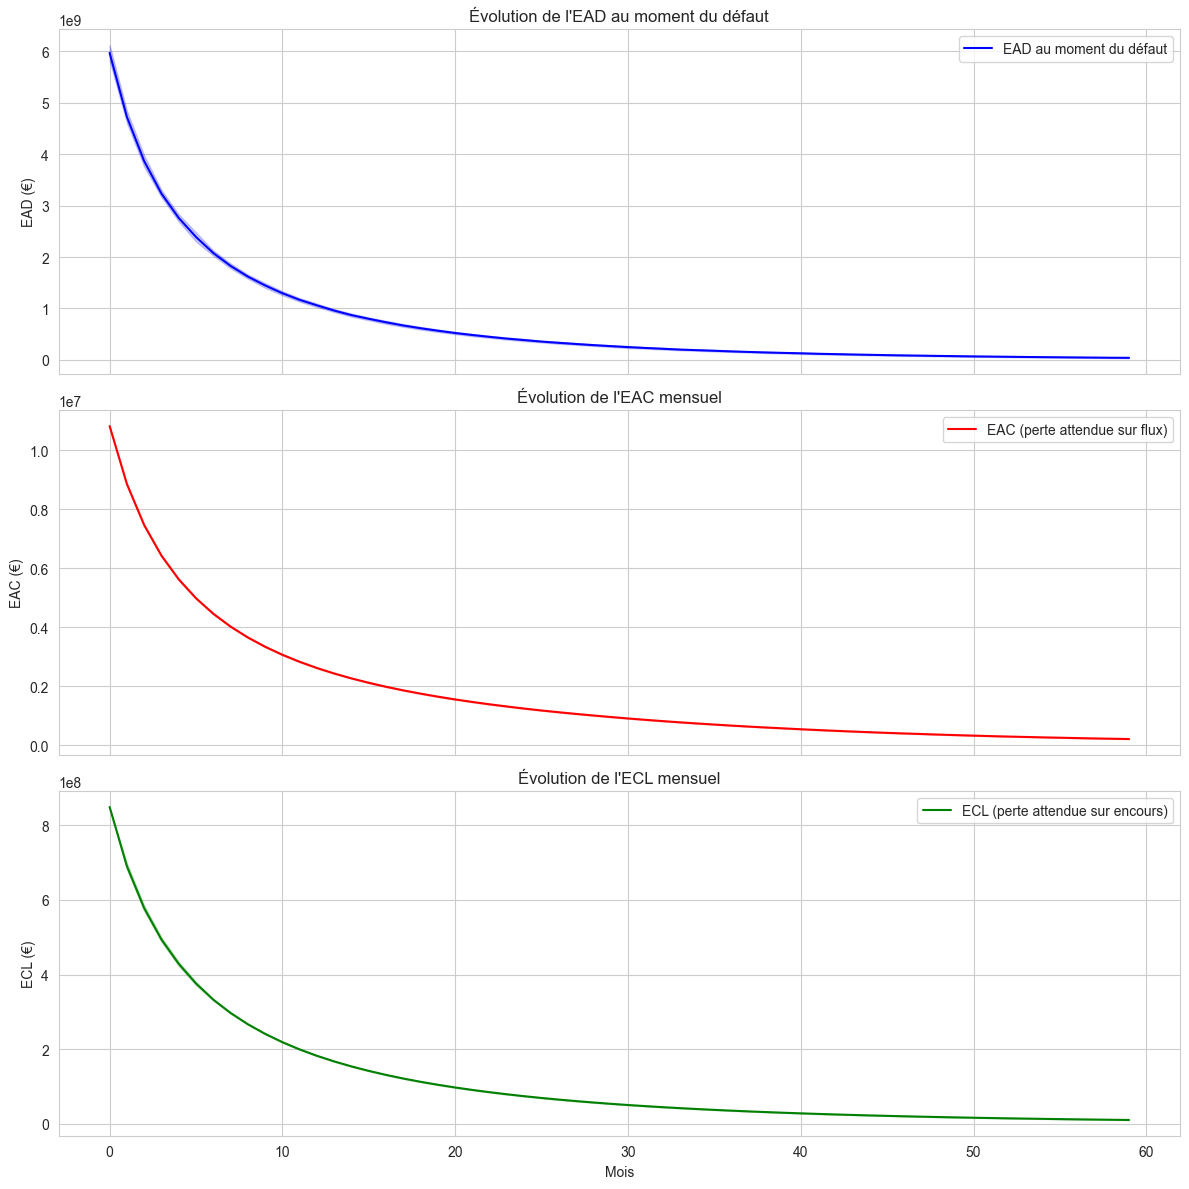

In [12]:
# Création du subplot
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# --- EAD au défaut
axes[0].plot(ead_mean, label="EAD au moment du défaut", color='blue')
axes[0].fill_between(range(temps_max), ead_mean - 2*ead_std, ead_mean + 2*ead_std, alpha=0.2, color='blue')
axes[0].set_ylabel("EAD (€)")
axes[0].set_title("Évolution de l'EAD au moment du défaut")
axes[0].legend()
axes[0].grid(True)

# --- EAC
axes[1].plot(eac_mean, label="EAC (perte attendue sur flux)", color='red')
axes[1].fill_between(range(temps_max), eac_mean - 2*eac_std, eac_mean + 2*eac_std, alpha=0.2, color='red')
axes[1].set_ylabel("EAC (€)")
axes[1].set_title("Évolution de l'EAC mensuel")
axes[1].legend()
axes[1].grid(True)

# --- ECL
axes[2].plot(ecl_mean, label="ECL (perte attendue sur encours)", color='green')
axes[2].fill_between(range(temps_max), ecl_mean - 2*ecl_std, ecl_mean + 2*ecl_std, alpha=0.2, color='green')
axes[2].set_ylabel("ECL (€)")
axes[2].set_xlabel("Mois")
axes[2].set_title("Évolution de l'ECL mensuel")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Analyse des résultats simulés – Monte Carlo (100 trajectoires)

Les graphiques ci-dessous présentent l’évolution moyenne de trois indicateurs fondamentaux dans la modélisation du risque de crédit, simulés sur 100 trajectoires Monte Carlo :
- l’**EAD au moment du défaut** (bleu),
- l’**EAC mensuel** (rouge),
- l’**ECL mensuel** (vert).

---

### 1. Évolution de l’EAD au moment du défaut

- L’EAD atteint un **niveau initial très élevé** (~6 milliards €), correspondant à l'exposition totale du portefeuille si tous les crédits entraient en défaut dès le départ.
- Il **diminue rapidement** au fil des mois, à mesure que les clients font défaut ou remboursent leur dette.
- La courbe présente une forme **exponentiellement décroissante**, typique d’un portefeuille fermé sans nouveaux prêts.

**Interprétation** : le portefeuille est initialement très risqué, mais la majorité de l’exposition disparaît dès les premiers mois sous l’effet des défauts simulés.

---

### 2. Évolution de l’EAC (Expected Accrued Cost)

- Le coût attendu sur les **flux mensuels** est d’environ **10 millions €** au départ.
- Il diminue rapidement, en cohérence avec la baisse du nombre de clients actifs et du montant des mensualités attendues.
- Cela traduit la **perte potentielle sur les flux futurs** en tenant compte de `PD × LGD` chaque mois.

**Interprétation** : l’essentiel du **risque de crédit immédiat** est concentré dans les premiers mois de vie du crédit, période à haut risque pour les établissements prêteurs.

---

### 3. Évolution de l’ECL (Expected Credit Loss)

- L’ECL est initialement d’environ **800 millions €**, et suit également une **décroissance rapide**, mais moins brutale que celle de l’EAC.
- Il représente la **perte attendue sur l’encours**, c’est-à-dire si un défaut survenait à l’instant \( t \).
- La trajectoire reflète l’évolution moyenne de l’encours pondéré par le risque.

**Interprétation** : l’exposition au risque de perte reste importante au début, car l’encours est encore conséquent, puis diminue avec l’amortissement et les défauts cumulés.

---

### Interprétation économique

Les trois indicateurs montrent que le **risque de crédit est très concentré au début du cycle de vie** des crédits. Cela reflète une réalité bien connue dans le secteur bancaire :

- Les clients les plus fragiles ont tendance à faire défaut tôt,
- Les flux futurs deviennent moins risqués à mesure que le crédit est remboursé,
- L’encours total diminue rapidement, ce qui réduit l’impact d’un défaut tardif.

**Conséquence** : du point de vue d’un établissement prêteur, il est crucial de :

- **provisionner fortement en début de vie** du crédit (notamment pour les prêts à profil risqué),
- anticiper le risque avec des modèles prudents dès l’octroi,
- surveiller particulièrement les premiers mois du crédit, qui concentrent l’essentiel du **coût du risque IFRS 9**.

---